In [13]:
import os
import torch
import pandas as pd
import scanpy as sc

In [14]:
from preprocess import fix_seed
random_seed = 2025
fix_seed(random_seed)

In [15]:
adata_omics1 = sc.read_h5ad("../dataset/Human_Tonsil/rna.h5ad")
adata_omics2 = sc.read_h5ad("../dataset/Human_Tonsil/protein.h5ad")
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

locs = pd.read_csv("../dataset/Human_Tonsil/locs.csv", index_col=0)

common_barcodes = adata_omics1.obs_names.intersection(locs.index)

adata_omics1 = adata_omics1[common_barcodes]
adata_omics2 = adata_omics2[common_barcodes]
locs_filtered = locs.loc[common_barcodes]

spatial_coords = locs_filtered[['2', '3']].values
adata_omics1.obsm['spatial'] = spatial_coords
adata_omics2.obsm['spatial'] = spatial_coords

print("after alignment:", adata_omics1.shape, adata_omics2.shape, spatial_coords.shape)

after alignment: (4194, 18085) (4194, 35) (4194, 2)


In [16]:
import anndata
import numpy as np
# img_emb can be obtained using Omiclip

img_emb = np.load("../dataset/Human_Tonsil/image_embeddings.npy")
nan_row_indices = np.where(np.isnan(img_emb).any(axis=1))[0]
adata_omics3 = anndata.AnnData(
    X=None,
    obs=adata_omics1.obs.copy(),
    var=adata_omics1.var.copy()
)
# image
adata_omics3.obsm['feat'] = img_emb.copy()

if 'spatial' in adata_omics1.obsm:
    adata_omics3.obsm['spatial'] = adata_omics1.obsm['spatial'].copy()

In [17]:
from preprocess import clr_normalize_each_cell, pca, lsi
n_protein = adata_omics2.n_vars

sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)

# RNA
adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=n_protein)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=n_protein)

In [18]:
from preprocess import construct_neighbor_graph
data = construct_neighbor_graph(adata_omics1, adata_omics2, adata_omics3)

3


In [19]:
from GROVER import Train_GROVER
# define model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Train_GROVER(data, device=device, epochs=300)
torch.autograd.set_detect_anomaly(True)
output = model.train()

100%|██████████| 300/300 [02:32<00:00,  1.97it/s]


In [20]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata.obsm['emb_latent_omics3'] = output['emb_latent_omics3'].copy()
adata.obsm['GROVER'] = output['GROVER'].copy()

In [ ]:
adata.write("../dataset/Human_Tonsil/Result.h5ad")

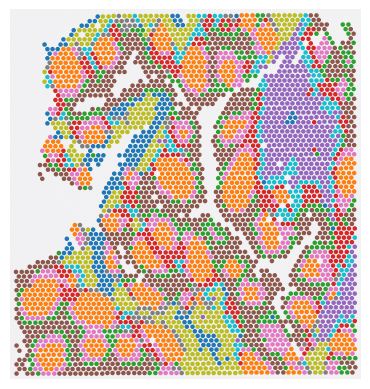

In [22]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from utils import cluster
from utils import plot_on_histology
import matplotlib.pyplot as plt
model.emb = adata.obsm['GROVER']
clusters = cluster(model,n_clusters=10)
im_lowres = plt.imread('../dataset/Human_Tonsil/he-raw.tif')
scale = 0.051109068
plot_on_histology(clusters, locs, im_lowres, scale, s=5)  